https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

https://machinelearningmastery.com/lstm-model-architecture-for-rare-event-time-series-forecasting/

https://www.mathworks.com/matlabcentral/fileexchange/69506-multivariate-and-univariate-time-series-prediction

In [35]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs

import numpy

/opt/anaconda3/envs/gva_p_3713/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## Data

In [14]:
strFileName = "/Users/gauchetvanantwerpen/Documents/01 gvaLokaalDocs/01 Pers/02 Nisse/02 development/02 nissedb/results/SOL.JO.csv"

df = pd.read_csv(strFileName, usecols=[0,4],  index_col=0,engine='python')



<AxesSubplot:xlabel='Date'>

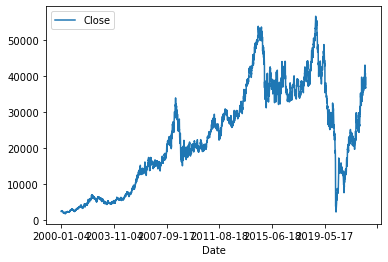

In [16]:
df.plot()

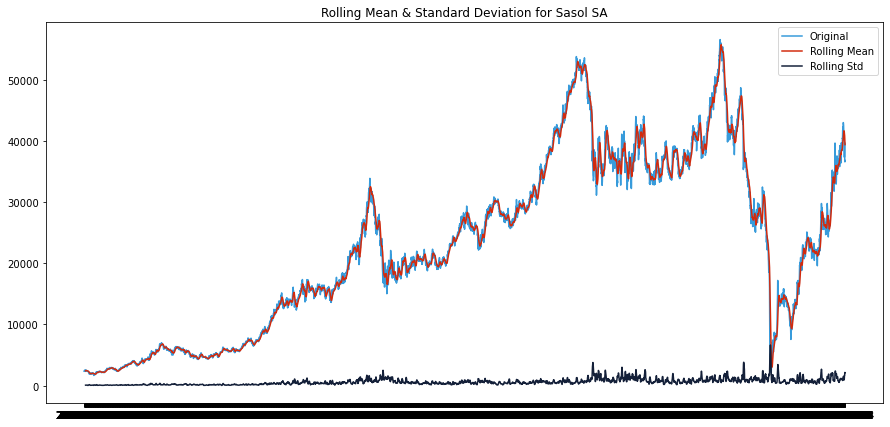

In [27]:
#Determine rolling statistics
df["rolling_avg"] = df["Close"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Close"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Close"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for Sasol SA')
plt.show(block=False)

In [36]:
result = adfuller(df.Close.dropna())
print('NumDiffs: %f' % ndiffs(df.Close.dropna(), test='adf'))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

NumDiffs: 1.000000
ADF Statistic: -1.701809
p-value: 0.430181


In [37]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -1.701809
p-value                           0.430181
#Lags Used                        2.000000
Number of Observations Used    5774.000000
Critical Value (1%)              -3.431483
Critical Value (5%)              -2.862041
Critical Value (10%)             -2.567037
dtype: float64


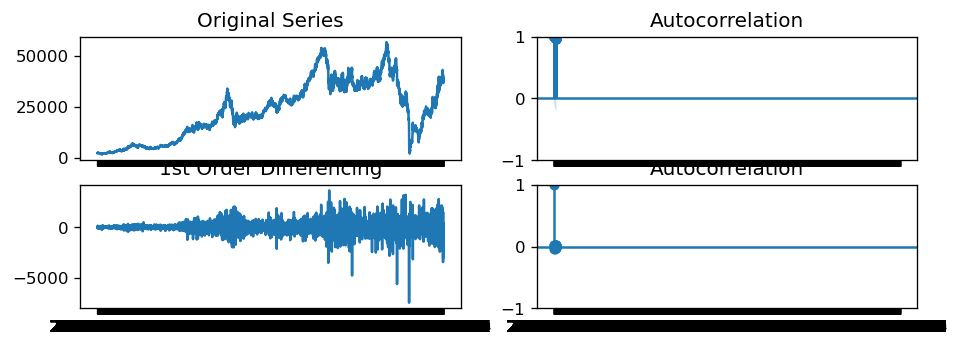

In [40]:
# Original Series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(df.Close.dropna()); axes[0, 0].set_title('Original Series')
plot_acf(df.Close, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df.Close.dropna().diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.dropna().diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
#axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
#plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

/opt/anaconda3/envs/gva_p_3713/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


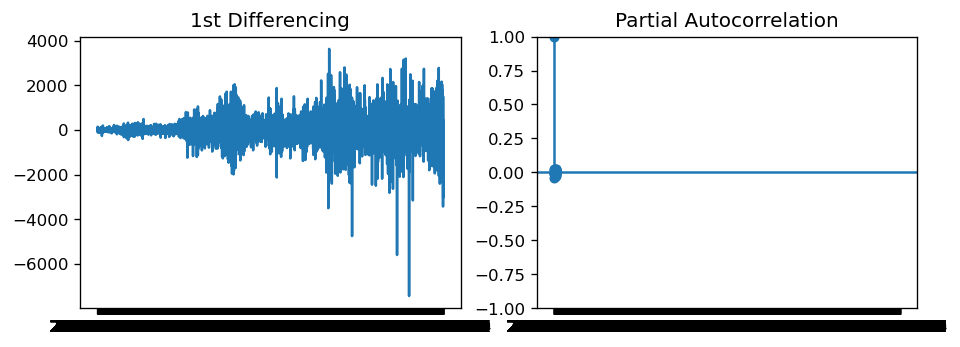

In [39]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Close.diff().dropna(), ax=axes[1])

plt.show()

## Preprocessing

### Date processing

In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

### Differenciation

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

### Scaling

In [2]:

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 


### Conversion

#### Machine Mastery

In [ ]:
"""Machine Mastery"""

# convert an array of values into a dataset matrix
def create_dataset_mm(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### UBER

In [24]:
"""Time series_UBER"""

def create_dataset_uber(dataset, look_back=1, forecast_horizon=1):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-1):
        #a = dataset[i:(i+look_back), 0]
        dataX.append(dataset[i:(look_back),])
        dataY.append(dataset[i + look_back:i + llok_back + forcasthorizon,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
trainX, trainY = create_dataset(train, look_back, forecast_horizon)
testX, testY = create_dataset(test, look_back, forecast_horizon)

## Processing

### Modelling

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    print(nb_epoch)
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        print(i)
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#### Uber

In [ ]:
model = Sequential()
model.add(LSTM(64, input_dim = features, input_length = look_back ... ))
model.add(LSTM(32, ... ))
model.add(Dense(forecast_horizon))
model.compile(loss = 'mean_squared_error', optimizer = 'sgd')
model.fit(trainX, trainY, validation_data=(testX, testY))

In [17]:
# transform data to be stationary

#raw_values = series.values
raw_values = df.values
diff_values = difference(raw_values, 1)

In [18]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [19]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [20]:
intEpocs = 100
intNeurons = 4
# fit the model
lstm_model = fit_lstm(train_scaled, 1, intEpocs, intNeurons)


100
0


2022-07-26 21:02:18.825176: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 21:02:18.827120: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [21]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[0.34131044],
       [0.35696888],
       [0.36028886],
       ...,
       [0.3634194 ],
       [0.36024088],
       [0.36294234]], dtype=float32)

In [22]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=42876.004208, Expected=42565.000000
Month=2, Predicted=42662.133359, Expected=41986.000000
Month=3, Predicted=42080.576464, Expected=41167.000000
Month=4, Predicted=41260.480298, Expected=40220.000000
Month=5, Predicted=40312.814846, Expected=40332.000000
Month=6, Predicted=40431.438854, Expected=40799.000000
Month=7, Predicted=40899.632016, Expected=37370.000000
Month=8, Predicted=37405.069101, Expected=38877.000000
Month=9, Predicted=38986.723181, Expected=39762.000000
Month=10, Predicted=39862.170785, Expected=36729.000000
Month=11, Predicted=36754.293678, Expected=36612.000000
Month=12, Predicted=36707.148713, Expected=36835.000000


Test RMSE: 1518.932


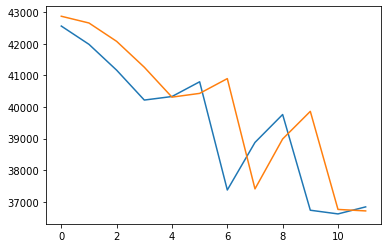

In [23]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()